In [3]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
import colorcet
import matplotlib as mpl
from astropy.table import QTable
from scipy import stats

plt.style.use('paper.mplstyle')

In [4]:
def get_hist(data, bins=None, nbins=50, logbins=False, norm=True, cum=False):

    """Get histogram

    Parameters
    ----------
    data : np.array
        input data
    bins : list
        input bin edges for histogram calculaiton; default=''
    nbins : int
        number of bins to determine if bins is not given; defult=50
    logbins : bool
        logarithmically spaced bins if bins is not given
    norm : bool
        normalise such that max is equal to unity; default=True
    cum : bool
        cumulative distorbution; otherwise probability distorbution
    Returns
    -------
    bins : list
        bin edges for histogram calculaiton
    bin_cent : np.array
        bin centres, for easy plotting in matplotlib
    hist : np.array
        histogram data for each bin centre
    """

    data = data.flatten()

    if bins.all() is None:
        vmin=np.nanmin(data)
        vmax=np.nanmax(data)

        bmin = vmin - (np.absolute(vmin)*1)
        bmax = vmax + (np.absolute(vmax)*0.3)

        if logbins:
            min = np.nanmin(data[data>0])
            bins = np.logspace(np.log10(bmin), np.log10(bmax), nbins+1)
        else:
            bins = np.linspace(bmin, bmax, nbins+1)
    else:
        nbins = len(bins)-1

    bins_cent = np.empty([nbins])

    for i in range(nbins):
        bins_cent[i] = np.nanmean([bins[i], bins[i+1]])

    hist = np.histogram(data.flatten(), bins)[0]

    if cum:
        hist = np.cumsum(hist)
    if norm:
        hist = hist/np.nanmax(hist)

    return(bins, bins_cent, hist)

In [5]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)
table

gal_name,region_ID,x_max,y_max,x_com,y_com,ra_max,dec_max,ra_com,dec_com,npix,HA6562_FLUX_HST,HA6562_FLUX_ERR_HST,area_exact,radius_circ,flux_max,flux_min,flux_mean,radius_circ_pc,x_mom,y_mom,ra_mom,dec_mom,area_ellipse,major_sigma,minor_sigma,mean_sigma,position_angle,mean_sigma_pc,complexity_score,flag_edge_hst,flag_touch_hst,cen_x_MUSE,cen_y_MUSE,cen_ra_MUSE,cen_dec_MUSE,cen_x_geo_MUSE,cen_y_geo_MUSE,flag_edge_MUSE,flag_nearby_MUSE,flag_star_MUSE,deproj_dist_MUSE,deproj_phi_MUSE,region_area_MUSE,region_circ_rad_MUSE,HB4861_FLUX_MUSE,OIII5006_FLUX_MUSE,HA6562_FLUX_MUSE,NII6583_FLUX_MUSE,SII6716_FLUX_MUSE,SII6730_FLUX_MUSE,SIII9068_FLUX_MUSE,OI6300_FLUX_MUSE,NII5754_FLUX_MUSE,HEI5875_FLUX_MUSE,SIII6312_FLUX_MUSE,OI6363_FLUX_MUSE,OII7319_FLUX_MUSE,OII7330_FLUX_MUSE,HB4861_FLUX_ERR_MUSE,OIII5006_FLUX_ERR_MUSE,HA6562_FLUX_ERR_MUSE,NII6583_FLUX_ERR_MUSE,SII6716_FLUX_ERR_MUSE,SII6730_FLUX_ERR_MUSE,SIII9068_FLUX_ERR_MUSE,OI6300_FLUX_ERR_MUSE,NII5754_FLUX_ERR_MUSE,HEI5875_FLUX_ERR_MUSE,SIII6312_FLUX_ERR_MUSE,OI6363_FLUX_ERR_MUSE,OII7319_FLUX_ERR_MUSE,OII7330_FLUX_ERR_MUSE,HA6562_SIGMA_MUSE,NII6583_SIGMA_MUSE,OIII5006_SIGMA_MUSE,HA6562_VEL_MUSE,NII6583_VEL_MUSE,OIII5006_VEL_MUSE,HA6562_SIGMA_ERR_MUSE,NII6583_SIGMA_ERR_MUSE,OIII5006_SIGMA_ERR_MUSE,HA6562_VEL_ERR_MUSE,NII6583_VEL_ERR_MUSE,OIII5006_VEL_ERR_MUSE,HB4861_FLUX_CORR_MUSE,OIII5006_FLUX_CORR_MUSE,HA6562_FLUX_CORR_MUSE,NII6583_FLUX_CORR_MUSE,SII6716_FLUX_CORR_MUSE,SII6730_FLUX_CORR_MUSE,SIII9068_FLUX_CORR_MUSE,OI6300_FLUX_CORR_MUSE,NII5754_FLUX_CORR_MUSE,HEI5875_FLUX_CORR_MUSE,SIII6312_FLUX_CORR_MUSE,OI6363_FLUX_CORR_MUSE,OII7319_FLUX_CORR_MUSE,OII7330_FLUX_CORR_MUSE,HB4861_FLUX_CORR_ERR_MUSE,OIII5006_FLUX_CORR_ERR_MUSE,HA6562_FLUX_CORR_ERR_MUSE,NII6583_FLUX_CORR_ERR_MUSE,SII6716_FLUX_CORR_ERR_MUSE,SII6730_FLUX_CORR_ERR_MUSE,SIII9068_FLUX_CORR_ERR_MUSE,OI6300_FLUX_CORR_ERR_MUSE,NII5754_FLUX_CORR_ERR_MUSE,HEI5875_FLUX_CORR_ERR_MUSE,SIII6312_FLUX_CORR_ERR_MUSE,OI6363_FLUX_CORR_ERR_MUSE,OII7319_FLUX_CORR_ERR_MUSE,OII7330_FLUX_CORR_ERR_MUSE,EBV_MUSE,EBV_ERR_MUSE,met_scal_MUSE,met_scal_err_MUSE,logq_D91_MUSE,logq_D91_err_MUSE,t_N2_MUSE,t_S3_MUSE,t_N2_err_MUSE,t_S3_err_MUSE,BPT_NII_MUSE,BPT_SII_MUSE,BPT_OI_MUSE,LOG_SIGMA_SFR_CHAB_MUSE,LOG_SIGMA_STMASS_CHAB_MUSE,5thNN_dist_MUSE,NN_number_MUSE,Environment_MUSE,r_R25_MUSE,r_reff_MUSE,HA6562_LUMINOSITY_MUSE,Delta_met_scal_MUSE,pc_per_pixel_MUSE,EW_HA6562_raw_MUSE,EW_HA6562_raw_ERR_MUSE,EW_HB4861_raw_MUSE,EW_HB4861_raw_ERR_MUSE,EW_HA6562_fit_MUSE,EW_HA6562_fit_ERR_MUSE,EW_HB4861_fit_MUSE,EW_HB4861_fit_ERR_MUSE,EW_HA6562_bgcorr_MUSE,EW_HA6562_bgcorr_ERR_MUSE,EW_HB4861_bgcorr_MUSE,EW_HB4861_bgcorr_ERR_MUSE,HII_class_v2_MUSE,HII_class_v3_MUSE,HA6562_FLUX_CORR_HST,HA6562_FLUX_ERR_CORR_HST,HA6562_LUMINOSITY_HST,HA6562_LUMINOSITY_ERR_HST,region_circ_rad_pc_MUSE
,,pix,pix,pix,pix,deg,deg,deg,deg,pix,erg / (s cm2),erg / (s cm2),arcsec2,arcsec,erg / (s cm2),erg / (s cm2),erg / (s cm2),pc,pix,pix,deg,deg,arcsec2,arcsec,arcsec,arcsec,deg,pc,,,,pix,pix,deg,deg,pix,pix,,,,arcsec,rad,pix2,arcsec,1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s 

In [6]:
mask_flags = ~((table['flag_edge_hst']==1)|(table['flag_edge_MUSE']==1)|(table['flag_star_MUSE']==1))
table = table[mask_flags]

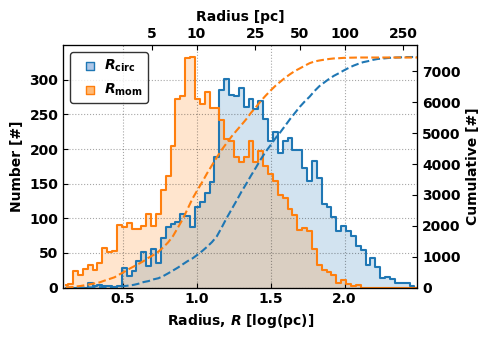

In [7]:
colors = mpl.cm.tab20(np.arange(0,20))
colors1 = colors[::2]
colors2 = colors[1::2]

data1 = np.log10(table['radius_circ_pc'].value)
data2 = np.log10(table['mean_sigma_pc'].value)

bins = np.linspace(0.1, np.nanmax([data1,data2]), 75)

bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3.5)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid', c='C0')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', fc='C0')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='$R_\mathrm{circ}$')

ax.plot(bins_cent2, hist2, ds='steps-mid', c='C1')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid', fc='C1')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='$R_\mathrm{mom}$')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.1, 2.49)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius, $R$ [log(pc)]')
ax.set_ylabel('Number [#]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')
ax.legend(loc='upper left', edgecolor='black', handletextpad=0)

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum, ls='--', c='C0')
running_sum = np.cumsum(hist2)
ax2.plot(bins_cent2, running_sum, ls='--', c='C1')

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radlog_sigma_all.pdf', dpi=250, bbox_inches='tight')

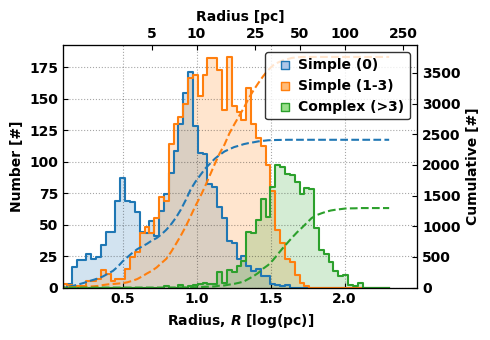

In [8]:
fig = plt.figure(figsize=(5, 3.5)) 
ax = fig.add_subplot(111)
ax2 = ax.twinx()

data1 = np.log10(table['mean_sigma_pc'].value)
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)

for complexity_score in zip([0, 1, 4], [1, 4, 500]):

    data1 = np.log10(table['mean_sigma_pc'].value)
    mask = (table['complexity_score'] >= complexity_score[0]) & (table['complexity_score'] < complexity_score[1])
    data1 = data1[mask]
    bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

    ax.plot(bins_cent1, hist1, ds='steps-mid')
    ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum, ls='--')

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#]')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.1, 2.49)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius, $R$ [log(pc)]')
ax.set_ylabel('Number [#]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

ax.grid(True, alpha=0.35, ls=':', color='black')

ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='Simple (0)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='Simple (1-3)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[2], fc=colors2[2], label='Complex (>3)')
ax2.legend(loc='upper right', edgecolor='black', handletextpad=0)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radlog_sigma_complex.pdf', dpi=250, bbox_inches='tight')

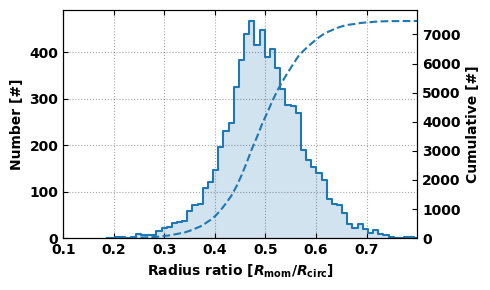

In [9]:
data1 = table['mean_sigma_pc'].value/table['radius_circ_pc'].value 
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)
bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.1, 0.8)

ax.set_xticks(np.arange(0.1,0.8,0.1))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius ratio [$R_\mathrm{mom}$/$R_\mathrm{circ}$]')
ax.set_ylabel('Number [#]')

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum, ls='--', c='C0')
ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radratio_sigma_all.pdf', dpi=250, bbox_inches='tight')

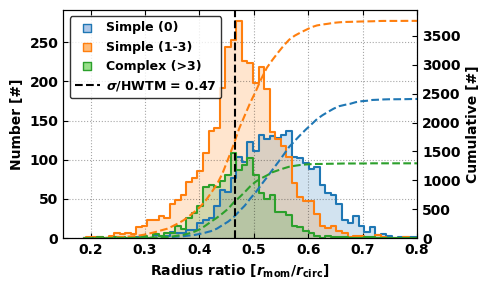

In [10]:
data1 = table['mean_sigma_pc'].value/table['radius_circ_pc'].value 
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)

fig = plt.figure(figsize=(5, 3)) 
ax = fig.add_subplot(111)
ax2 = ax.twinx()

for complexity_score in zip([0, 1, 4], [1, 4, 500]):

    data1 = table['mean_sigma_pc'].value/table['radius_circ_pc'].value 
    mask = (table['complexity_score'] >= complexity_score[0]) & (table['complexity_score'] < complexity_score[1])
    data1 = data1[mask]
    bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

    ax.plot(bins_cent1, hist1, ds='steps-mid')
    ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum, ls='--')


ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.15, 0.8)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius ratio [$r_\mathrm{mom}/r_\mathrm{circ}$]')
ax.set_ylabel('Number [#]')

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#]')

ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='Simple (0)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='Simple (1-3)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[2], fc=colors2[2], label='Complex (>3)')

ax2.plot([2/4.292, 2/4.292], [0, 1e4], ls='--', c='black', label='$\sigma$/HWTM = %0.2f' %(2/4.292))

ax2.legend(loc='upper left', edgecolor='black', handletextpad=0.5, fontsize=9)
fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radratio_sigma_complex.pdf', dpi=250, bbox_inches='tight')

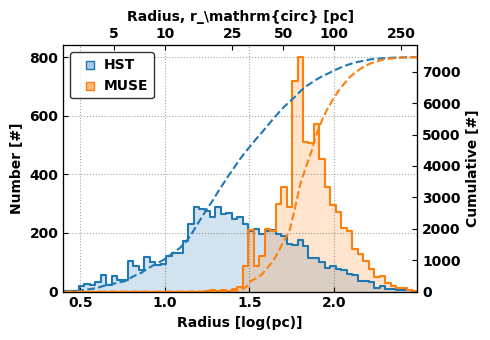

In [11]:
colors = mpl.cm.tab20(np.arange(0,20))
colors1 = colors[::2]
colors2 = colors[1::2]

data1 = np.log10(table['radius_circ_pc'].value)
data2 = np.log10(table['region_circ_rad_pc_MUSE'].value)

bins = np.linspace(0.2, np.nanmax([data1,data2]), 75)

bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3.5)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid', c='C0')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', fc='C0')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='HST')

ax.plot(bins_cent2, hist2, ds='steps-mid', c='C1')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid', fc='C1')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='MUSE')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.4, 2.49)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius [log(pc)]')
ax.set_ylabel('Number [#]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius, r_\mathrm{circ} [pc]')
ax.legend(loc='upper left', edgecolor='black', handletextpad=0)

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum, ls='--', c='C0')
running_sum = np.cumsum(hist2)
ax2.plot(bins_cent2, running_sum, ls='--', c='C1')

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radlog_all.pdf', dpi=250, bbox_inches='tight')

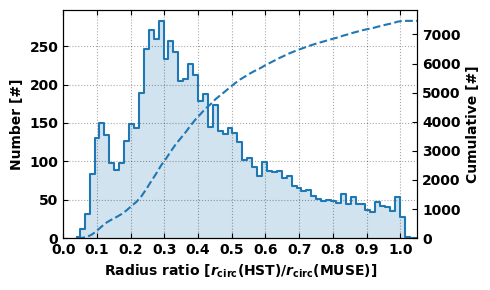

In [12]:
data1 = table['radius_circ_pc'].value/table['region_circ_rad_pc_MUSE'].value
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)
bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0, 1.05)

ax.set_xticks(np.arange(0,1.1,0.1))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius ratio [$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$]')
ax.set_ylabel('Number [#]')

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum, ls='--', c='C0')
ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radratio_all.pdf', dpi=250, bbox_inches='tight')

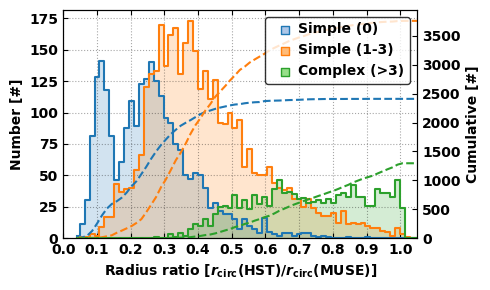

In [13]:
data1 = table['radius_circ_pc'].value/table['region_circ_rad_pc_MUSE'].value
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)

fig = plt.figure(figsize=(5, 3)) 
ax = fig.add_subplot(111)
ax2 = ax.twinx()

for complexity_score in zip([0, 1, 4], [1, 4, 500]):

    data1 = table['radius_circ_pc'].value/table['region_circ_rad_pc_MUSE'].value
    mask = (table['complexity_score'] >= complexity_score[0]) & (table['complexity_score'] < complexity_score[1])
    data1 = data1[mask]
    bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

    ax.plot(bins_cent1, hist1, ds='steps-mid')
    ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum, ls='--')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0, 1.05)

ax.set_xticks(np.arange(0,1.1,0.1))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius ratio [$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$]')
ax.set_ylabel('Number [#]')

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#]')

ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='Simple (0)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='Simple (1-3)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[2], fc=colors2[2], label='Complex (>3)')
ax2.legend(loc='upper right', edgecolor='black', handletextpad=0)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radratio_complex.pdf', dpi=250, bbox_inches='tight')

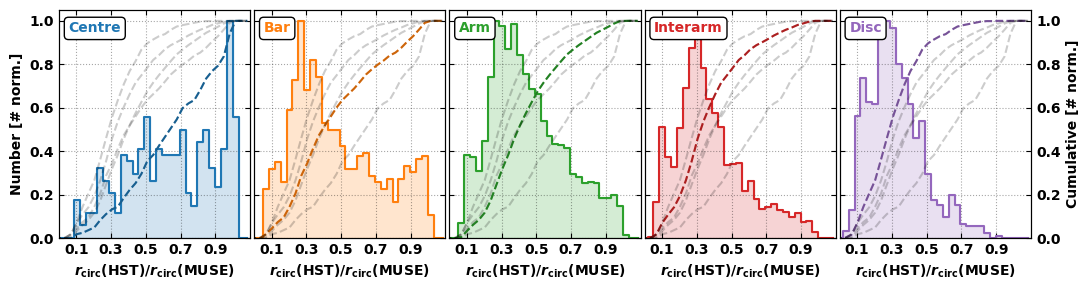

In [14]:
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']
hist_all = []
running_sum_all = []

for i, environment in enumerate(environments):

    data_1 = table['radius_circ_pc'].value
    data_2 = table['region_circ_rad_pc_MUSE'].value

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_1_, data_2_ = data_1[mask_env], data_2[mask_env]
    data = data_1_/data_2_

    bins = np.linspace(-0.05, 1.1, 35)
    bins1, bins_cent1, hist1 = get_hist(data, bins=bins, norm=True)
    hist_all += [hist1]
    running_sum_all += [np.cumsum(hist1)]


fig = plt.figure(figsize=(11,3)) 
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']

for i, environment in enumerate(environments):

    ax = fig.add_subplot(1,5,i+1)

    data_1 = table['radius_circ_pc'].value
    data_2 = table['region_circ_rad_pc_MUSE'].value

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_1_, data_2_ = data_1[mask_env], data_2[mask_env]
    data = data_1_/data_2_

    bins = np.linspace(-0.05, 1.1, 35)
    bins1, bins_cent1, hist1 = get_hist(data, bins=bins, norm=True)

    ax.plot(bins_cent1, hist1, ds='steps-mid', c='C%i'%i)
    ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', fc='C%i'%i, ec='C%i'%i)
    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, environments_names[i], ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    ax.set_xticks(np.arange(0.1,1.1,0.2))
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$')

    ax2 = ax.twinx()
    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum/np.nanmax(running_sum), ls='--', c='C%i'%i)
    ylim = ax2.get_ylim()
    ax2.set_ylim(0, ylim[-1])

    for j in range(len(environments)):
        ax2.plot(bins_cent1, running_sum_all[j]/np.nanmax(running_sum_all[j]), c='black', alpha=0.2, ls='--')

    if i in [0]:
        ax.set_ylabel('Number [# norm.]')
    else:
        ax.set_yticklabels([])
    if i in [4]:
        ax2.set_ylabel('Cumulative [# norm.]')
    else:
        ax2.set_yticklabels([])

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/hist_radratio_env.pdf', dpi=250, bbox_inches='tight')

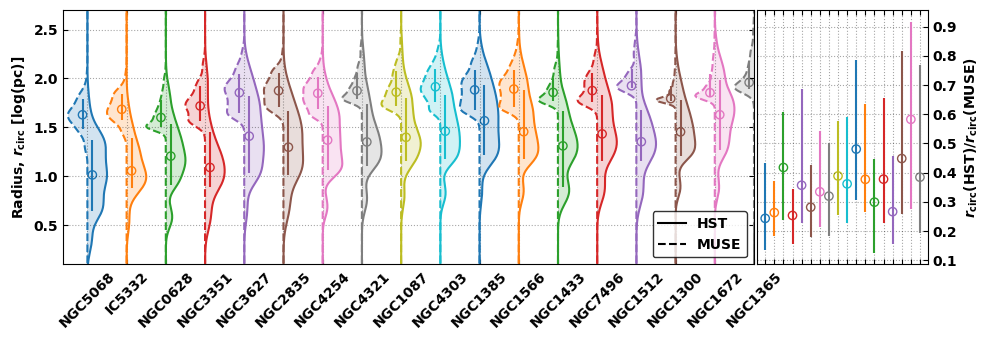

In [15]:
gal_names = table['gal_name'][np.unique(table['pc_per_pixel_MUSE'], return_index=True)[-1]]

data1 = np.log10(table['radius_circ_pc'].value)
data2 = np.log10(table['region_circ_rad_pc_MUSE'].value)

bins     = np.linspace(0.2, np.nanmax([data1,data2]), 50)
bins_kde = np.linspace(0, 3, 200)

fig = plt.figure(figsize=(10, 3.5)) 

ax = plt.subplot2grid((1, 5), (0, 0), rowspan=1, colspan=4)
ax2 = plt.subplot2grid((1, 5), (0, 4), rowspan=1, colspan=1)

# Rest of the code...

for i, gal_name in enumerate(gal_names):

    mask = table['gal_name'] == gal_name

    data1_masked = data1[mask]
    data2_masked = data2[mask]

    kde1 = stats.gaussian_kde(data1_masked)
    kde2 = stats.gaussian_kde(data2_masked)
    
    kde1_data = kde1(bins_kde)/np.nanmax(kde1(bins_kde))
    kde2_data = kde2(bins_kde)/np.nanmax(kde2(bins_kde))

    kde1_data = kde1_data+(i*2)
    kde2_data = (kde2_data*-1)+(i*2)

    ax.plot(kde1_data, bins_kde, c='C%i'%i)
    ax.plot(kde2_data, bins_kde, c='C%i'%i, ls='--')

    ax.fill_between(kde1_data, bins_kde, alpha=0.2, step='mid', fc='C%i'%i, ec='none', y2=0)
    ax.fill_between(kde2_data, bins_kde, alpha=0.2, step='mid', fc='C%i'%i, ec='none', y2=0)

    ax.scatter([(i*2)+0.25], [np.nanmedian(data1_masked)], ec='C%i'%i, fc='none')
    ax.scatter([(i*2)-0.25], [np.nanmedian(data2_masked)], ec='C%i'%i, fc='none')

    ax.errorbar([(i*2)+0.25], [np.nanmedian(data1_masked)], yerr=[[np.nanmedian(data1_masked)-np.nanpercentile(data1_masked, 16)], [np.nanpercentile(data1_masked, 84)-np.nanmedian(data1_masked)]], fmt='none', c='C%i'%i)
    ax.errorbar([(i*2)-0.25], [np.nanmedian(data2_masked)], yerr=[[np.nanmedian(data2_masked)-np.nanpercentile(data2_masked, 16)], [np.nanpercentile(data2_masked, 84)-np.nanmedian(data2_masked)]], fmt='none', c='C%i'%i)

ax.plot([0,0], [0,0], c='k', label='HST')
ax.plot([0,0], [0,0], c='k', ls='--', label='MUSE')

ax.legend(loc='lower right', edgecolor='black')

ax.set_ylim(0.1, 2.7)

# axa = ax.twinx()
# axa.set_ylim(ax.get_ylim())
# new_tick_locations = np.log10([2,5,10,25,50,100,250])
# axa.set_yticks(new_tick_locations)
# axa.set_yticklabels(np.round(np.power(10, new_tick_locations)).astype(int))

ax.set_ylabel('Radius, $r_\mathrm{circ}$ [log(pc)]')
# axa.set_ylabel('Radius [pc]')

ax.set_xlim(-1.25, 33.25)
ax.set_xticks(np.arange(0,len(gal_names)*2,2))
ax.set_xticklabels(gal_names, rotation=45, ha='center')

# axa = ax.twiny()
# axa.set_xlim(ax.get_xlim())
# new_tick_locations = np.arange(0,len(gal_names)*2,2)
# axa.set_xticks(new_tick_locations)
# axa.set_xticklabels(np.round(pc_per_pixel_MUSE.value))

# Add side panel plot
for i, gal_name in enumerate(gal_names):

    mask = table['gal_name'] == gal_name

    data1_masked = data1[mask]
    data2_masked = data2[mask]

    data = 10**(data1_masked-data2_masked)

    ax2.scatter([(i*2)], [np.nanmedian(data)], ec='C%i'%i, fc='none')
    ax2.errorbar([i*2], [np.nanmedian(data)], yerr=[[np.nanmedian(data)-np.nanpercentile(data, 16)], [np.nanpercentile(data, 84)-np.nanmedian(data)]], fmt='none', c='C%i'%i)

ax2.set_ylabel('$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$')
ax2.set_xticks(np.arange(0,len(gal_names)*2,2))
ax2.set_xticklabels([])
ax2.yaxis.set_ticks_position("right")
ax2.yaxis.set_label_position("right")

ax.grid(True, alpha=0.35, ls=':', color='black')
ax2.grid(True, alpha=0.35, ls=':', color='black')

fig.tight_layout(h_pad=0.5, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/hist_radratio_gal.pdf', dpi=250, bbox_inches='tight')

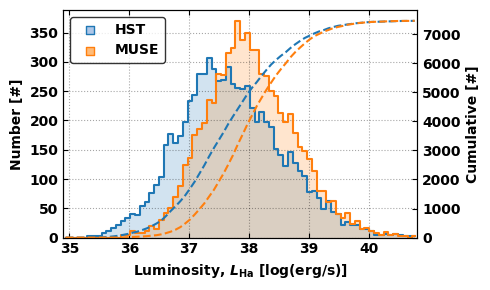

In [16]:
data1 = np.log10(np.array(table['HA6562_LUMINOSITY_HST'].value))
data2 = np.log10(np.array(table['HA6562_LUMINOSITY_MUSE'].value))

bins = np.linspace(34.9, 40.8, 75)

bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid', c='C0')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', fc='C0')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='HST')

ax.plot(bins_cent2, hist2, ds='steps-mid', c='C1')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid', fc='C1')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='MUSE')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(np.percentile(bins, [0,100]))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Luminosity, $L_\mathrm{Ha}$ [log(erg/s)]')
ax.set_ylabel('Number [#]')

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum, ls='--', c='C0')
running_sum = np.cumsum(hist2)
ax2.plot(bins_cent2, running_sum, ls='--', c='C1')
ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax.legend(loc='upper left', edgecolor='black')

plt.savefig('./figs/hist_lum_all.pdf', dpi=250, bbox_inches='tight')

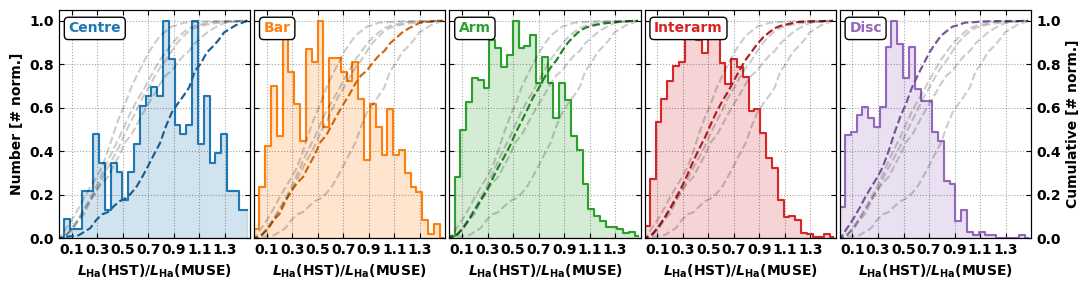

In [17]:
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']
hist_all = []
running_sum_all = []

for i, environment in enumerate(environments):

    data_1 = np.array(table['HA6562_LUMINOSITY_HST'].value)
    data_2 = np.array(table['HA6562_LUMINOSITY_MUSE'].value)

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_1_, data_2_ = data_1[mask_env], data_2[mask_env]
    data = data_1_/data_2_

    bins = np.linspace(-0.05, 1.5, 35)
    bins1, bins_cent1, hist1 = get_hist(data, bins=bins, norm=True)
    hist_all += [hist1]
    running_sum_all += [np.cumsum(hist1)]

fig = plt.figure(figsize=(11,3)) 

# environments = np.unique(table['Environment'])
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']

for i, environment in enumerate(environments):

    ax = fig.add_subplot(1,5,i+1)

    data_1 = np.array(table['HA6562_LUMINOSITY_HST'].value)
    data_2 = np.array(table['HA6562_LUMINOSITY_MUSE'].value)

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_1_, data_2_ = data_1[mask_env], data_2[mask_env]
    data = data_1_/data_2_

    bins = np.linspace(-0.05, 1.5, 35)
    bins1, bins_cent1, hist1 = get_hist(data, bins=bins, norm=True)

    ax.plot(bins_cent1, hist1, ds='steps-mid', c='C%i'%i)
    ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', fc='C%i'%i, ec='C%i'%i)

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, environments_names[i], ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    ax.set_xticks(np.arange(0.1,1.5,0.2))
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('$L_\mathrm{Ha}(\mathrm{HST})/L_\mathrm{Ha}(\mathrm{MUSE})$')

    ax2 = ax.twinx()
    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum/np.nanmax(running_sum), ls='--', c='C%i'%i)    
    ylim = ax2.get_ylim()
    ax2.set_ylim(0, ylim[-1])

    for j in range(len(environments)):
        ax2.plot(bins_cent1, running_sum_all[j]/np.nanmax(running_sum_all[j]), c='black', alpha=0.2, ls='--')

    if i in [0]:
        ax.set_ylabel('Number [# norm.]')
    else:
        ax.set_yticklabels([])
    if i in [4]:
        ax2.set_ylabel('Cumulative [# norm.]')
    else:
        ax2.set_yticklabels([])

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/hist_lumratio_env.pdf', dpi=250, bbox_inches='tight')

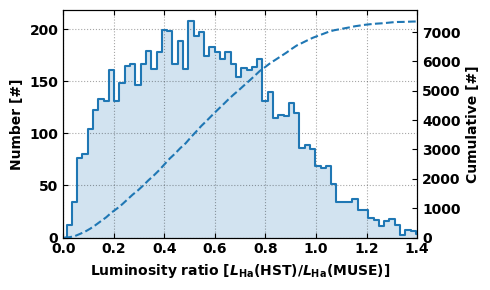

In [18]:
data1 = table['HA6562_LUMINOSITY_HST'].value/table['HA6562_LUMINOSITY_MUSE'].value

bins = np.linspace(-0.05, 1.5, 75)

bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0, 1.1)

ax.set_xticks(np.arange(0,1.5,0.2))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Luminosity ratio [$L_\mathrm{Ha}(\mathrm{HST})/L_\mathrm{Ha}(\mathrm{MUSE})$]')
ax.set_ylabel('Number [#]')

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum, ls='--', c='C0')
ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_lumratio_all.pdf', dpi=250, bbox_inches='tight')

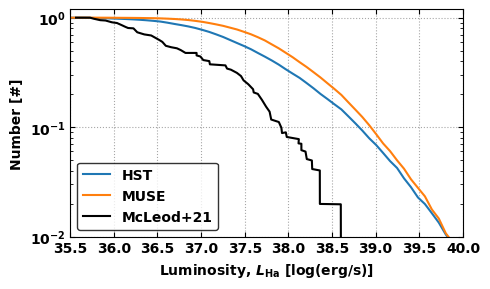

In [87]:
cumulative1_m21 = QTable.read('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/pressures_literature/McLeod2021_ngc300/McLeod2021_ngc300_cumdist.csv', format='ascii.csv', data_start=1)
cumulative1_m21['number'] = 10**cumulative1_m21['number']

cumulative1_m21['number'] = (cumulative1_m21['number']/np.nanmax(cumulative1_m21['number'])) 

data1 = np.log10(np.array(table['HA6562_LUMINOSITY_HST'].value))
data2 = np.log10(np.array(table['HA6562_LUMINOSITY_MUSE'].value))

bins = np.linspace(34.9, 40.8, 75)
bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)

running_sum1 = np.cumsum(hist1)
running_sum2 = np.cumsum(hist2)

cumulative1 = (np.nanmax(running_sum1) - running_sum1)/np.nanmax(running_sum1)
cumulative2 = (np.nanmax(running_sum1) - running_sum2)/np.nanmax(running_sum2)

# cumulative1 = (np.nanmax(running_sum1) - running_sum1)
# cumulative2 = (np.nanmax(running_sum1) - running_sum2)

fig = plt.figure(figsize=(5, 3)) 
ax = fig.add_subplot(111)

ax.plot(bins_cent1, cumulative1, ls='-', c='C0', label='HST')
ax.plot(bins_cent2, cumulative2, ls='-', c='C1', label='MUSE')
ax.plot(cumulative1_m21['Lum'], cumulative1_m21['number'], ls='-', c='black', label='McLeod+21')

ax.set_yscale('log')
ax.set_ylim(1e-2, 1.2)
ax.set_xlim(35.5, 40)

ax.grid(True, alpha=0.35, ls=':', color='black')
ax.set_xlabel('Luminosity, $L_\mathrm{Ha}$ [log(erg/s)]')
ax.set_ylabel('Number [#]')
fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax.legend(loc='lower left', edgecolor='black')

# plt.savefig('./figs/hist_lum_all.pdf', dpi=250, bbox_inches='tight')

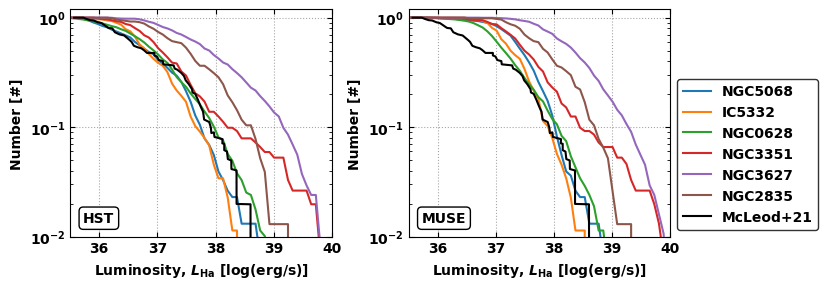

In [106]:
cumulative1_m21 = QTable.read('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/pressures_literature/McLeod2021_ngc300/McLeod2021_ngc300_cumdist.csv', format='ascii.csv', data_start=1)
cumulative1_m21['number'] = 10**cumulative1_m21['number']

cumulative1_m21['number'] = (cumulative1_m21['number']/np.nanmax(cumulative1_m21['number'])) 

data1 = np.log10(np.array(table['HA6562_LUMINOSITY_HST'].value))
data2 = np.log10(np.array(table['HA6562_LUMINOSITY_MUSE'].value))

bins = np.linspace(34.9, 40.8, 75)
fig = plt.figure(figsize=(7, 3)) 
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i, gal_name in enumerate(gal_names):

    if i > 5: 
        continue

    mask = table['gal_name'] == gal_name

    data1_masked = data1[mask]
    data2_masked = data2[mask]

    bins1, bins_cent1, hist1 = get_hist(data1_masked, bins=bins, norm=False)
    bins2, bins_cent2, hist2 = get_hist(data2_masked, bins=bins, norm=False)

    running_sum1 = np.cumsum(hist1)
    running_sum2 = np.cumsum(hist2)

    cumulative1 = (np.nanmax(running_sum1) - running_sum1)/np.nanmax(running_sum1)
    cumulative2 = (np.nanmax(running_sum1) - running_sum2)/np.nanmax(running_sum2)

    ax1.plot(bins_cent1, cumulative1, ls='-', c='C%i' %i, label='%s' %gal_name)
    ax2.plot(bins_cent2, cumulative2, ls='-', c='C%i' %i, label='%s' %gal_name)

ax1.plot(cumulative1_m21['Lum'], cumulative1_m21['number'], ls='-', c='black', label='McLeod+21')
ax2.plot(cumulative1_m21['Lum'], cumulative1_m21['number'], ls='-', c='black', label='McLeod+21')

ax1.text(0.05, 0.05, 'HST', ha='left', va='bottom', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax1.transAxes, color='black')
ax2.text(0.05, 0.05, 'MUSE', ha='left', va='bottom', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax2.transAxes, color='black')

for ax in [ax1, ax2]: 

    ax.set_yscale('log')
    ax.set_ylim(1e-2, 1.2)
    ax.set_xlim(35.5, 40)

    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.set_xlabel('Luminosity, $L_\mathrm{Ha}$ [log(erg/s)]')
    ax.set_ylabel('Number [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax.legend(loc='lower left', edgecolor='black', bbox_to_anchor=(1, 0))

# plt.savefig('./figs/hist_lum_all.pdf', dpi=250, bbox_inches='tight')

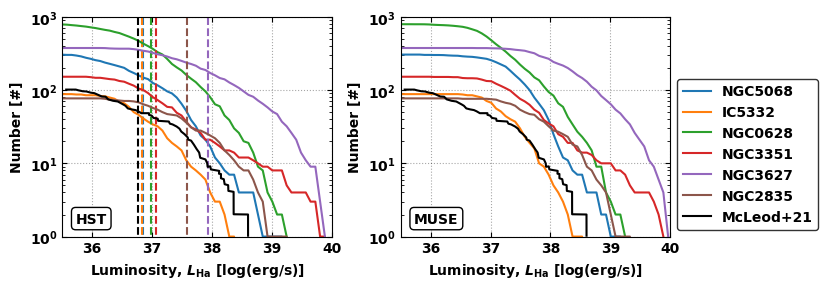

In [125]:
cumulative1_m21 = QTable.read('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/pressures_literature/McLeod2021_ngc300/McLeod2021_ngc300_cumdist.csv', format='ascii.csv', data_start=1)
cumulative1_m21['number'] = 10**cumulative1_m21['number']

# cumulative1_m21['number'] = (cumulative1_m21['number']/np.nanmax(cumulative1_m21['number'])) 

data1 = np.log10(np.array(table['HA6562_LUMINOSITY_HST'].value))
data2 = np.log10(np.array(table['HA6562_LUMINOSITY_MUSE'].value))

bins = np.linspace(34.9, 40.8, 75)
fig = plt.figure(figsize=(7, 3)) 
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i, gal_name in enumerate(gal_names):

    if i > 5: 
        continue

    mask = table['gal_name'] == gal_name

    data1_masked = data1[mask]
    data2_masked = data2[mask]

    bins1, bins_cent1, hist1 = get_hist(data1_masked, bins=bins, norm=False)
    bins2, bins_cent2, hist2 = get_hist(data2_masked, bins=bins, norm=False)

    running_sum1 = np.cumsum(hist1)
    running_sum2 = np.cumsum(hist2)

    cumulative1 = (np.nanmax(running_sum1) - running_sum1)
    cumulative2 = (np.nanmax(running_sum1) - running_sum2)

    ax1.plot(bins_cent1, cumulative1, ls='-', c='C%i' %i, label='%s' %gal_name)
    ax2.plot(bins_cent2, cumulative2, ls='-', c='C%i' %i, label='%s' %gal_name)

    ax1.plot([np.median(data1_masked)]*2, [0,1e5], ls='--', c='C%i' %i)

ax1.plot(cumulative1_m21['Lum'], cumulative1_m21['number'], ls='-', c='black', label='McLeod+21')
ax2.plot(cumulative1_m21['Lum'], cumulative1_m21['number'], ls='-', c='black', label='McLeod+21')
ax1.plot([cumulative1_m21['Lum'][20]]*2, [0,1e5], ls='--', c='black')


ax1.text(0.05, 0.05, 'HST', ha='left', va='bottom', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax1.transAxes, color='black')
ax2.text(0.05, 0.05, 'MUSE', ha='left', va='bottom', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax2.transAxes, color='black')

for ax in [ax1, ax2]: 

    ax.set_yscale('log')
    ax.set_ylim(1, 1e3)
    ax.set_xlim(35.5, 40)

    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.set_xlabel('Luminosity, $L_\mathrm{Ha}$ [log(erg/s)]')
    ax.set_ylabel('Number [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax.legend(loc='lower left', edgecolor='black', bbox_to_anchor=(1, 0))

# plt.savefig('./figs/hist_lum_all.pdf', dpi=250, bbox_inches='tight')